#Implementation of Block Neural Autoregressive Flow
http://arxiv.org/abs/1904.04676

Implementation adapted from:
https://github.com/nicola-decao/BNAF
and
https://github.com/kamenbliznashki/normalizing_flows


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torch.utils.data import DataLoader, TensorDataset

import math
import os
import time
import argparse
import pprint
from functools import partial

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from tqdm import tqdm

import json

import datetime
from torch.utils import data

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
density_estimation_dir = "drive/MyDrive/density_estimation/"
data_dir = os.path.join(density_estimation_dir, "data/")
# checkpoint_dir = os.path.join(density_estimation_dir, "checkpoint/")
checkpoint_dir = "checkpoint/"
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

In [4]:
# !mkdir -p $checkpoint_dir

In [5]:
!ls $density_estimation_dir

checkpoint  data


## Real Data

### MiniBooNe

In [6]:
import numpy as np

class MINIBOONE:
    class Data:
        def __init__(self, data):

            self.x = data.astype(np.float32)
            self.N = self.x.shape[0]

    def __init__(self, file):

        trn, val, tst = load_data_normalised(file)

        self.trn = self.Data(trn)
        self.val = self.Data(val)
        self.tst = self.Data(tst)

        self.n_dims = self.trn.x.shape[1]


def load_data(root_path):
    # NOTE: To remember how the pre-processing was done.
    # data = pd.read_csv(root_path, names=[str(x) for x in range(50)], delim_whitespace=True)
    # print data.head()
    # data = data.as_matrix()
    # # Remove some random outliers
    # indices = (data[:, 0] < -100)
    # data = data[~indices]
    #
    # i = 0
    # # Remove any features that have too many re-occuring real values.
    # features_to_remove = []
    # for feature in data.T:
    #     c = Counter(feature)
    #     max_count = np.array([v for k, v in sorted(c.iteritems())])[0]
    #     if max_count > 5:
    #         features_to_remove.append(i)
    #     i += 1
    # data = data[:, np.array([i for i in range(data.shape[1]) if i not in features_to_remove])]
    # np.save("~/data/miniboone/data.npy", data)

    data = np.load(root_path)
    N_test = int(0.1 * data.shape[0])
    data_test = data[-N_test:]
    data = data[0:-N_test]
    N_validate = int(0.1 * data.shape[0])
    data_validate = data[-N_validate:]
    data_train = data[0:-N_validate]

    return data_train, data_validate, data_test


def load_data_normalised(root_path):

    data_train, data_validate, data_test = load_data(root_path)
    data = np.vstack((data_train, data_validate))
    mu = data.mean(axis=0)
    s = data.std(axis=0)
    data_train = (data_train - mu) / s
    data_validate = (data_validate - mu) / s
    data_test = (data_test - mu) / s

    return data_train, data_validate, data_test

## Model components

In [7]:
import math

class Sequential(torch.nn.Sequential):
    """
    Class that extends ``torch.nn.Sequential`` for computing the output of
    the function alongside with the log-det-Jacobian of such transformation.
    """

    def forward(self, inputs: torch.Tensor):
        """
        Parameters
        ----------
        inputs : ``torch.Tensor``, required.
            The input tensor.
        Returns
        -------
        The output tensor and the log-det-Jacobian of this transformation.
        """

        log_det_jacobian = 0.0
        for i, module in enumerate(self._modules.values()):
            inputs, log_det_jacobian_ = module(inputs)
            log_det_jacobian = log_det_jacobian + log_det_jacobian_
        return inputs, log_det_jacobian

class Permutation(torch.nn.Module):
    """
    Module that outputs a permutation of its input.
    """

    def __init__(self, in_features: int, p: list = None):
        """
        Parameters
        ----------
        in_features : ``int``, required.
            The number of input features.
        p : ``list`` or ``str``, optional (default = None)
            The list of indeces that indicate the permutation. When ``p`` is not a
            list, if ``p = 'flip'``the tensor is reversed, if ``p = None`` a random
            permutation is applied.
        """

        super(Permutation, self).__init__()

        self.in_features = in_features

        if p is None:
            self.p = np.random.permutation(in_features)
        elif p == "flip":
            self.p = list(reversed(range(in_features)))
        else:
            self.p = p

    def forward(self, inputs: torch.Tensor):
        """
        Parameters
        ----------
        inputs : ``torch.Tensor``, required.
            The input tensor.
        Returns
        -------
        The permuted tensor and the log-det-Jacobian of this permutation.
        """

        return inputs[:, self.p], 0

    def __repr__(self):
        return "Permutation(in_features={}, p={})".format(self.in_features, self.p)


class MaskedWeight(torch.nn.Module):
    """
    Module that implements a linear layer with block matrices with positive diagonal blocks.
    Moreover, it uses Weight Normalization (https://arxiv.org/abs/1602.07868) for stability.
    """

    def __init__(
        self, in_features: int, out_features: int, dim: int, bias: bool = True
    ):
        """
        Parameters
        ----------
        in_features : ``int``, required.
            The number of input features per each dimension ``dim``.
        out_features : ``int``, required.
            The number of output features per each dimension ``dim``.
        dim : ``int``, required.
            The number of dimensions of the input of the flow.
        bias : ``bool``, optional (default = True).
            Whether to add a parametrizable bias.
        """

        super(MaskedWeight, self).__init__()
        self.in_features, self.out_features, self.dim = in_features, out_features, dim

        weight = torch.zeros(out_features, in_features)
        for i in range(dim):
            weight[
                i * out_features // dim : (i + 1) * out_features // dim,
                0 : (i + 1) * in_features // dim,
            ] = torch.nn.init.xavier_uniform_(
                torch.Tensor(out_features // dim, (i + 1) * in_features // dim)
            )

        self._weight = torch.nn.Parameter(weight)
        self._diag_weight = torch.nn.Parameter(
            torch.nn.init.uniform_(torch.Tensor(out_features, 1)).log()
        )

        self.bias = (
            torch.nn.Parameter(
                torch.nn.init.uniform_(
                    torch.Tensor(out_features),
                    -1 / math.sqrt(out_features),
                    1 / math.sqrt(out_features),
                )
            )
            if bias
            else 0
        )

        mask_d = torch.zeros_like(weight)
        for i in range(dim):
            mask_d[
                i * (out_features // dim) : (i + 1) * (out_features // dim),
                i * (in_features // dim) : (i + 1) * (in_features // dim),
            ] = 1

        self.register_buffer("mask_d", mask_d)

        mask_o = torch.ones_like(weight)
        for i in range(dim):
            mask_o[
                i * (out_features // dim) : (i + 1) * (out_features // dim),
                i * (in_features // dim) :,
            ] = 0

        self.register_buffer("mask_o", mask_o)

    def get_weights(self):
        """
        Computes the weight matrix using masks and weight normalization.
        It also compute the log diagonal blocks of it.
        """

        w = torch.exp(self._weight) * self.mask_d + self._weight * self.mask_o

        w_squared_norm = (w ** 2).sum(-1, keepdim=True)

        w = self._diag_weight.exp() * w / w_squared_norm.sqrt()

        wpl = self._diag_weight + self._weight - 0.5 * torch.log(w_squared_norm)

        return w.t(), wpl.t()[self.mask_d.bool().t()].view(
            self.dim, self.in_features // self.dim, self.out_features // self.dim
        )

    def forward(self, inputs, grad: torch.Tensor = None):
        """
        Parameters
        ----------
        inputs : ``torch.Tensor``, required.
            The input tensor.
        grad : ``torch.Tensor``, optional (default = None).
            The log diagonal block of the partial Jacobian of previous transformations.
        Returns
        -------
        The output tensor and the log diagonal blocks of the partial log-Jacobian of previous
        transformations combined with this transformation.
        """

        w, wpl = self.get_weights()

        g = wpl.transpose(-2, -1).unsqueeze(0).repeat(inputs.shape[0], 1, 1, 1)

        return (
            inputs.matmul(w) + self.bias,
            torch.logsumexp(g.unsqueeze(-2) + grad.transpose(-2, -1).unsqueeze(-3), -1)
            if grad is not None
            else g,
        )

    def __repr__(self):
        return "MaskedWeight(in_features={}, out_features={}, dim={}, bias={})".format(
            self.in_features,
            self.out_features,
            self.dim,
            not isinstance(self.bias, int),
        )


In [8]:
class MaskedLinear(nn.Module):
    def __init__(self, in_features, out_features, data_dim):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.data_dim = data_dim

        # Notation:
        # BNAF weight calculation for (eq 8): W = g(W) * M_d + W * M_o
        #   where W is block lower triangular so model is autoregressive,
        #         g = exp function; M_d is block diagonal mask; M_o is block off-diagonal mask.
        # Weight Normalization (Salimans & Kingma, eq 2): w = g * v / ||v||
        #   where g is scalar, v is k-dim vector, ||v|| is Euclidean norm
        # ------
        # Here: pre-weight norm matrix is v; then: v = exp(weight) * mask_d + weight * mask_o
        #       weight-norm scalar is g: out_features dimensional vector (here logg is used instead to avoid taking logs in the logdet calc.
        #       then weight-normed weight matrix is w = g * v / ||v||
        #
        #       log det jacobian of block lower triangular is taking block diagonal mask of
        #           log(g*v/||v||) = log(g) + log(v) - log(||v||)
        #                          = log(g) + weight - log(||v||) since v = exp(weight) * mask_d + weight * mask_o

        weight = torch.zeros(out_features, in_features)
        mask_d = torch.zeros_like(weight)
        mask_o = torch.zeros_like(weight)
        for i in range(data_dim):
            # select block slices
            h     = slice(i * out_features // data_dim, (i+1) * out_features // data_dim)
            w     = slice(i * in_features // data_dim,  (i+1) * in_features // data_dim)
            w_row = slice(0,                            (i+1) * in_features // data_dim)
            # initialize block-lower-triangular weight and construct block diagonal mask_d and lower triangular mask_o
            nn.init.kaiming_uniform_(weight[h,w_row], a=math.sqrt(5))  # default nn.Linear weight init only block-wise
            mask_d[h,w] = 1
            mask_o[h,w_row] = 1

        mask_o = mask_o - mask_d  # remove diagonal so mask_o is lower triangular 1-off the diagonal

        self.weight = nn.Parameter(weight)                          # pre-mask, pre-weight-norm
        self.logg = nn.Parameter(torch.rand(out_features, 1).log()) # weight-norm parameter
        self.bias = nn.Parameter(nn.init.uniform_(torch.rand(out_features), -1/math.sqrt(in_features), 1/math.sqrt(in_features)))  # default nn.Linear bias init
        self.register_buffer('mask_d', mask_d)
        self.register_buffer('mask_o', mask_o)

    def forward(self, x, sum_logdets):
        # 1. compute BNAF masked weight eq 8
        v = self.weight.exp() * self.mask_d + self.weight * self.mask_o
        # 2. weight normalization
        v_norm = v.norm(p=2, dim=1, keepdim=True)
        w = self.logg.exp() * v / v_norm
        # 3. compute output and logdet of the layer
        out = F.linear(x, w, self.bias)
        logdet = self.logg + self.weight - 0.5 * v_norm.pow(2).log()
        logdet = logdet[self.mask_d.byte()]
        logdet = logdet.view(1, self.data_dim, out.shape[1]//self.data_dim, x.shape[1]//self.data_dim) \
                       .expand(x.shape[0],-1,-1,-1)  # output (B, data_dim, out_dim // data_dim, in_dim // data_dim)

        # 4. sum with sum_logdets from layers before (BNAF section 3.3)
        # Compute log det jacobian of the flow (eq 9, 10, 11) using log-matrix multiplication of the different layers.
        # Specifically for two successive MaskedLinear layers A -> B with logdets A and B of shapes
        #  logdet A is (B, data_dim, outA_dim, inA_dim)
        #  logdet B is (B, data_dim, outB_dim, inB_dim) where outA_dim = inB_dim
        #
        #  Note -- in the first layer, inA_dim = in_features//data_dim = 1 since in_features == data_dim.
        #            thus logdet A is (B, data_dim, outA_dim, 1)
        #
        #  Then:
        #  logsumexp(A.transpose(2,3) + B) = logsumexp( (B, data_dim, 1, outA_dim) + (B, data_dim, outB_dim, inB_dim) , dim=-1)
        #                                  = logsumexp( (B, data_dim, 1, outA_dim) + (B, data_dim, outB_dim, outA_dim), dim=-1)
        #                                  = logsumexp( (B, data_dim, outB_dim, outA_dim), dim=-1) where dim2 of tensor1 is broadcasted
        #                                  = (B, data_dim, outB_dim, 1)

        sum_logdets = torch.logsumexp(sum_logdets.transpose(2,3) + logdet, dim=-1, keepdim=True)

        return out, sum_logdets


    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

class Tanh(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, sum_logdets):
        # derivation of logdet:
        # d/dx tanh = 1 / cosh^2; cosh = (1 + exp(-2x)) / (2*exp(-x))
        # log d/dx tanh = - 2 * log cosh = -2 * (x - log 2 + log(1 + exp(-2x)))
        logdet = -2 * (x - math.log(2) + F.softplus(-2*x))
        sum_logdets = sum_logdets + logdet.view_as(sum_logdets)
        return x.tanh(), sum_logdets

class FlowSequential(nn.Sequential):
    """ Container for layers of a normalizing flow """
    def forward(self, x):
        sum_logdets = torch.zeros(1, x.shape[1], 1, 1, device=x.device)
        for module in self:
            x, sum_logdets = module(x, sum_logdets)
        return x, sum_logdets.squeeze()



## BNAF Model

In [9]:
class BNAF_old(nn.Module):
    def __init__(self, data_dim, n_hidden, hidden_dim):
        super().__init__()

        # base distribution for calculation of log prob under the model
        self.register_buffer('base_dist_mean', torch.zeros(data_dim))
        self.register_buffer('base_dist_var', torch.ones(data_dim))

        # construct model
        modules = []
        modules += [MaskedLinear(data_dim, hidden_dim, data_dim), Tanh()]
        for _ in range(n_hidden):
            modules += [MaskedLinear(hidden_dim, hidden_dim, data_dim), Tanh()]
        modules += [MaskedLinear(hidden_dim, data_dim, data_dim)]
        self.net = FlowSequential(*modules)

        # TODO --   add permutation
        #           add residual gate
        #           add stack of flows

    @property
    def base_dist(self):
        return D.Normal(self.base_dist_mean, self.base_dist_var)

    def forward(self, x):
        return self.net(x)



# class BNAF(nn.Module):
#     def __init__(self, args, res: str = None):
#         super().__init__()

#         # base distribution for calculation of log prob under the model
#         self.register_buffer('base_dist_mean', torch.zeros(args.n_dims))
#         self.register_buffer('base_dist_var', torch.ones(args.n_dims))

#         # construct model
#         modules = []
#         modules += [MaskedLinear(args.n_dims, args.hidden_dim, args.n_dims), Tanh()]
#         for _ in range(args.layers):
#             modules += [MaskedLinear(args.hidden_dim, args.hidden_dim, args.n_dims), Tanh()]
#         modules += [MaskedLinear(args.hidden_dim, args.n_dims, args.n_dims)]
#         self.net = FlowSequential(*modules)

#         # TODO --   add permutation
#         #           add residual gate
#         #           add stack of flows

In [10]:
# def test_f(*args):
#     print(args[0].n_dims)

# test_f(args)

In [11]:
class BNAF(torch.nn.Sequential):
    """
    Class that extends ``torch.nn.Sequential`` for constructing a Block Neural
    Normalizing Flow.
    """

    def __init__(self, *args, res: str = None):
        """
        Parameters
        ----------
        *args : ``Iterable[torch.nn.Module]``, required.
            The modules to use.
        res : ``str``, optional (default = None).
            Which kind of residual connection to use. ``res = None`` is no residual
            connection, ``res = 'normal'`` is ``x + f(x)`` and ``res = 'gated'`` is
            ``a * x + (1 - a) * f(x)`` where ``a`` is a learnable parameter.
        """

        super(BNAF, self).__init__(*args)
        # # base distribution for calculation of log prob under the model
        # self.register_buffer('base_dist_mean', args[0].n_dims) # args.n_dims
        # self.register_buffer('base_dist_var', args[0].n_dims) # args.n_dims

        self.res = res

        if res == "gated":
            self.gate = torch.nn.Parameter(torch.nn.init.normal_(torch.Tensor(1)))

    # I added this... doesn't quite work
    # #at property
    # def base_dist(self):
    #     return D.Normal(self.base_dist_mean, self.base_dist_var)

    def forward(self, inputs: torch.Tensor):
        """
        Parameters
        ----------
        inputs : ``torch.Tensor``, required.
            The input tensor.
        Returns
        -------
        The output tensor and the log-det-Jacobian of this transformation.
        """

        outputs = inputs
        grad = None

        for module in self._modules.values():
            outputs, grad = module(outputs, grad)

            grad = grad if len(grad.shape) == 4 else grad.view(grad.shape + [1, 1])

        assert inputs.shape[-1] == outputs.shape[-1]

        if self.res == "normal":
            return inputs + outputs, torch.nn.functional.softplus(grad.squeeze()).sum(
                -1
            )
        elif self.res == "gated":
            return self.gate.sigmoid() * outputs + (1 - self.gate.sigmoid()) * inputs, (
                torch.nn.functional.softplus(grad.squeeze() + self.gate)
                - torch.nn.functional.softplus(self.gate)
            ).sum(-1)
        else:
            return outputs, grad.squeeze().sum(-1)

    def _get_name(self):
        return "BNAF(res={})".format(self.res)


Functionality for computing log probs

In [12]:
def compute_kl_qp_loss(model, target_potential_fn, batch_size):
    """ Compute BNAF eq 3 & 20:
    KL(q_inv||p) where q_inv is the inverse flow transform (log_q_inv = log_q_base - logdet), p is the target distribution (energy potential)
    Returns the minimization objective for density matching. """
    z = model.base_dist.sample((batch_size,))
    q_log_prob = model.base_dist.log_prob(z)
    zk, logdet = model(z)
    p_log_prob = - target_potential_fn(zk)  # p = exp(-potential) => log_p = - potential
    return q_log_prob.sum(1) - logdet.sum(1) - p_log_prob  # BNAF eq 20

def compute_kl_pq_loss(model, sample_2d_data_fn, batch_size):
    """ Compute BNAF eq 2 & 16:
    KL(p||q_fwd) where q_fwd is the forward flow transform (log_q_fwd = log_q_base + logdet), p is the target distribution.
    Returns the minimization objective for density estimation (NLL under the flow since the entropy of the target dist is fixed wrt the optimization) """
    sample = sample_2d_data_fn(batch_size).to(model.base_dist.loc.device)
    z, logdet = model(sample)
    return - torch.sum(model.base_dist.log_prob(z) + logdet, dim=1)


## Load Data

In [13]:
NAF_PARAMS = {
    # "power": (414213, 828258),
    # "gas": (401741, 803226),
    # "hepmass": (9272743, 18544268),
    "miniboone": (7487321, 14970256)
    # "bsds300": (36759591, 73510236),
}

def load_dataset(args):
    if args.dataset == "miniboone":
        data_path = os.path.join(data_dir, "miniboone/data.npy")
        # dataset = MINIBOONE("data/miniboone/data.npy")
        dataset = MINIBOONE(data_path)
    else:
        raise RuntimeError()

    dataset_train = torch.utils.data.TensorDataset(
        torch.from_numpy(dataset.trn.x).float().to(args.device)
    )
    data_loader_train = torch.utils.data.DataLoader(
        dataset_train, batch_size=args.batch_dim, shuffle=True
    )

    dataset_valid = torch.utils.data.TensorDataset(
        torch.from_numpy(dataset.val.x).float().to(args.device)
    )
    data_loader_valid = torch.utils.data.DataLoader(
        dataset_valid, batch_size=args.batch_dim, shuffle=False
    )

    dataset_test = torch.utils.data.TensorDataset(
        torch.from_numpy(dataset.tst.x).float().to(args.device)
    )
    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=args.batch_dim, shuffle=False
    )

    # hopefully this patch will fix things... specifying that n_dims is int
    args.n_dims = int(dataset.n_dims)

    return data_loader_train, data_loader_valid, data_loader_test

## Create the model

In [14]:
def create_model(args, verbose=False):

    flows = []
    for f in range(args.flows):
        layers = []
        for _ in range(args.layers - 1):
            layers.append(
                MaskedWeight(
                    args.n_dims * args.hidden_dim,
                    args.n_dims * args.hidden_dim,
                    dim=args.n_dims,
                )
            )
            layers.append(Tanh())

        flows.append(
            BNAF(
                *(
                    [
                        MaskedWeight(
                            args.n_dims, args.n_dims * args.hidden_dim, dim=args.n_dims
                        ),
                        Tanh(),
                    ]
                    + layers
                    + [
                        MaskedWeight(
                            args.n_dims * args.hidden_dim, args.n_dims, dim=args.n_dims
                        )
                    ]
                ),
                res=args.residual if f < args.flows - 1 else None
            )
        )

        if f < args.flows - 1:
            flows.append(Permutation(args.n_dims, "flip"))

    model = Sequential(*flows).to(args.device)
    params = sum(
        (p != 0).sum() if len(p.shape) > 1 else torch.tensor(p.shape).item()
        for p in model.parameters()
    ).item()

    if verbose:
        print("{}".format(model))
        print(
            "Parameters={}, NAF/BNAF={:.2f}/{:.2f}, n_dims={}".format(
                params,
                NAF_PARAMS[args.dataset][0] / params,
                NAF_PARAMS[args.dataset][1] / params,
                args.n_dims,
            )
        )

    if args.save and not args.load:
        with open(os.path.join(args.load or args.path, "results.txt"), "a") as f:
            print(
                "Parameters={}, NAF/BNAF={:.2f}/{:.2f}, n_dims={}".format(
                    params,
                    NAF_PARAMS[args.dataset][0] / params,
                    NAF_PARAMS[args.dataset][1] / params,
                    args.n_dims,
                ),
                file=f,
            )

    return model


Functionality for log probs

In [15]:
def compute_log_p_x(model, x_mb):
    y_mb, log_diag_j_mb = model(x_mb)
    log_p_y_mb = (
        torch.distributions.Normal(torch.zeros_like(y_mb), torch.ones_like(y_mb))
        .log_prob(y_mb)
        .sum(-1)
    )
    return log_p_y_mb + log_diag_j_mb

## Utils for checkpointing

In [16]:
def save_model(model, optimizer, epoch, args):
    def f():
        if args.save:
            print("Saving model..")
            torch.save(
                {
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "epoch": epoch,
                },
                os.path.join(args.load or args.path, "checkpoint.pt"),
            )

    return f


def load_model(model, optimizer, args, load_start_epoch=False):
    def f():
        print("Loading model..")
        checkpoint = torch.load(os.path.join(args.load or args.path, "checkpoint.pt"))
        model.load_state_dict(checkpoint["model"])
        optimizer.load_state_dict(checkpoint["optimizer"])

        if load_start_epoch:
            args.start_epoch = checkpoint["epoch"]

    return f


## Modified Optimizers

### Modified Adam

Modified version of Adam that can take Polyak decay term... see Polyak averaging
https://home.ttic.edu/~shubhendu/Pages/Files/Lecture6_flat.pdf
From Risi Kondor's group

In [17]:
class Adam(torch.optim.Optimizer):
    def __init__(
        self,
        params,
        lr=1e-3,
        betas=(0.9, 0.999),
        eps=1e-8,
        weight_decay=0,
        amsgrad=False,
        polyak=0.0,
    ):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= polyak <= 1.0:
            raise ValueError("Invalid polyak decay term: {}".format(polyak))

        defaults = dict(
            lr=lr,
            betas=betas,
            eps=eps,
            weight_decay=weight_decay,
            amsgrad=amsgrad,
            polyak=polyak,
        )
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault("amsgrad", False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        "Adam does not support sparse gradients, please consider SparseAdam instead"
                    )
                amsgrad = group["amsgrad"]

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state["step"] = 0
                    # Exponential moving average of gradient values
                    state["exp_avg"] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state["exp_avg_sq"] = torch.zeros_like(p.data)
                    # Exponential moving average of param
                    state["exp_avg_param"] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state["max_exp_avg_sq"] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                if amsgrad:
                    max_exp_avg_sq = state["max_exp_avg_sq"]
                beta1, beta2 = group["betas"]

                state["step"] += 1

                if group["weight_decay"] != 0:
                    grad.add_(group["weight_decay"], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group["eps"])
                else:
                    denom = exp_avg_sq.sqrt().add_(group["eps"])

                bias_correction1 = 1 - beta1 ** state["step"]
                bias_correction2 = 1 - beta2 ** state["step"]
                step_size = group["lr"] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

                polyak = self.defaults["polyak"]
                state["exp_avg_param"] = (
                    polyak * state["exp_avg_param"] + (1 - polyak) * p.data
                )

        return loss

    def swap(self):
        """
        Swapping the running average of params and the current params for saving parameters using polyak averaging
        """
        for group in self.param_groups:
            for p in group["params"]:
                state = self.state[p]
                new = p.data
                p.data = state["exp_avg_param"]
                state["exp_avg_param"] = new

    def substitute(self):
        for group in self.param_groups:
            for p in group["params"]:
                p.data = self.state[p]["exp_avg_param"]


### Modified LR scheduler: ReduceLROnPlateua

In [18]:
class ReduceLROnPlateau(torch.optim.lr_scheduler.ReduceLROnPlateau):
    def __init__(self, *args, early_stopping=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.early_stopping = early_stopping
        self.early_stopping_counter = 0

    def step(self, metrics, epoch=None, callback_best=None, callback_reduce=None):
        current = metrics
        if epoch is None:
            epoch = self.last_epoch = self.last_epoch + 1
        self.last_epoch = epoch

        if self.is_better(current, self.best):
            self.best = current
            self.num_bad_epochs = 0
            self.early_stopping_counter = 0
            if callback_best is not None:
                callback_best()
        else:
            self.num_bad_epochs += 1
            self.early_stopping_counter += 1

        if self.in_cooldown:
            self.cooldown_counter -= 1
            self.num_bad_epochs = 0  # ignore any bad epochs in cooldown

        if self.num_bad_epochs > self.patience:
            if callback_reduce is not None:
                callback_reduce()
            self._reduce_lr(epoch)
            self.cooldown_counter = self.cooldown
            self.num_bad_epochs = 0

        return self.early_stopping_counter == self.early_stopping

## Training

In [19]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
def train(
    model,
    optimizer,
    scheduler,
    data_loader_train,
    data_loader_valid,
    data_loader_test,
    args,
):

    if args.tensorboard:
        from tensorboardX import SummaryWriter

        writer = SummaryWriter(os.path.join(args.tensorboard, args.load or args.path))

    epoch = args.start_epoch
    for epoch in range(args.start_epoch, args.start_epoch + args.epochs):

        t = tqdm(data_loader_train, smoothing=0, ncols=80)
        train_loss = []

        for (x_mb,) in t:
            # aha! key
            loss = -compute_log_p_x(model, x_mb).mean()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=args.clip_norm)

            optimizer.step()
            optimizer.zero_grad()

            t.set_postfix(loss="{:.2f}".format(loss.item()), refresh=False)
            train_loss.append(loss)

        train_loss = torch.stack(train_loss).mean()
        optimizer.swap()
        validation_loss = -torch.stack(
            [
                compute_log_p_x(model, x_mb).mean().detach()
                for x_mb, in data_loader_valid
            ],
            -1,
        ).mean()
        optimizer.swap()

        print(
            "Epoch {:3}/{:3} -- train_loss: {:4.3f} -- validation_loss: {:4.3f}".format(
                epoch + 1,
                args.start_epoch + args.epochs,
                train_loss.item(),
                validation_loss.item(),
            )
        )

        stop = scheduler.step(
            validation_loss,
            callback_best=save_model(model, optimizer, epoch + 1, args),
            callback_reduce=load_model(model, optimizer, args),
        )

        if args.tensorboard:
            writer.add_scalar("lr", optimizer.param_groups[0]["lr"], epoch + 1)
            writer.add_scalar("loss/validation", validation_loss.item(), epoch + 1)
            writer.add_scalar("loss/train", train_loss.item(), epoch + 1)

        if stop:
            break

    load_model(model, optimizer, args)()
    optimizer.swap()
    validation_loss = -torch.stack(
        [compute_log_p_x(model, x_mb).mean().detach() for x_mb, in data_loader_valid],
        -1,
    ).mean()
    test_loss = -torch.stack(
        [compute_log_p_x(model, x_mb).mean().detach() for x_mb, in data_loader_test], -1
    ).mean()

    print("###### Stop training after {} epochs!".format(epoch + 1))
    print("Validation loss: {:4.3f}".format(validation_loss.item()))
    print("Test loss:       {:4.3f}".format(test_loss.item()))

    if args.save:
        with open(os.path.join(args.load or args.path, "results.txt"), "a") as f:
            print("###### Stop training after {} epochs!".format(epoch + 1), file=f)
            print("Validation loss: {:4.3f}".format(validation_loss.item()), file=f)
            print("Test loss:       {:4.3f}".format(test_loss.item()), file=f)


## Execute

### Set parameters

In [21]:
parser = argparse.ArgumentParser()
parser.add_argument("--device", type=str, default="cuda:0")
# parser.add_argument('--cuda', type=int, help='Which GPU to run on.')
parser.add_argument('--seed', type=int, default=0, help='Random seed.')
parser.add_argument(
    "--dataset",
    type=str,
    default="miniboone",
    choices=["gas", "bsds300", "hepmass", "miniboone", "power"],
)

parser.add_argument("--learning_rate", type=float, default=1e-2)
parser.add_argument("--batch_dim", type=int, default=200)
parser.add_argument("--clip_norm", type=float, default=0.1)
parser.add_argument("--epochs", type=int, default=1000)

parser.add_argument("--patience", type=int, default=20)
parser.add_argument("--cooldown", type=int, default=10)
parser.add_argument("--early_stopping", type=int, default=100)
parser.add_argument("--decay", type=float, default=0.5)
parser.add_argument("--min_lr", type=float, default=5e-4)
parser.add_argument("--polyak", type=float, default=0.998)

parser.add_argument("--flows", type=int, default=5)
parser.add_argument("--layers", type=int, default=1)
parser.add_argument("--hidden_dim", type=int, default=10)
parser.add_argument(
    "--residual", type=str, default="gated", choices=[None, "normal", "gated"]
)

parser.add_argument("--expname", type=str, default="")
parser.add_argument("--load", type=str, default=None)
parser.add_argument("--save", action="store_true")
parser.add_argument("--tensorboard", type=str, default="tensorboard")


_StoreAction(option_strings=['--tensorboard'], dest='tensorboard', nargs=None, const=None, default='tensorboard', type=<class 'str'>, choices=None, required=False, help=None, metavar=None)

In [22]:
args = parser.parse_args("")

# print("Arguments:")
# pprint.pprint(args.__dict__)

In [23]:
args

Namespace(device='cuda:0', seed=0, dataset='miniboone', learning_rate=0.01, batch_dim=200, clip_norm=0.1, epochs=1000, patience=20, cooldown=10, early_stopping=100, decay=0.5, min_lr=0.0005, polyak=0.998, flows=5, layers=1, hidden_dim=10, residual='gated', expname='', load=None, save=False, tensorboard='tensorboard')

In [24]:
# python density_estimation.py --dataset miniboone \  # which dataset to use
#                              --flows 5 \            # BNAF flows to concatenate
#                              --layers 0 \           # layers for each flow of BNAF
#                              --hidden_dim 10 \      # hidden units per dimension for each hidden layer
#                              --save                 # save the model after training

In [25]:
# args.cuda = 0
args.seed = 0
args.epochs = 200
args.dataset = 'miniboone'
# args.flows = 5
# args.layers = 0
args.hidden_dim = 40 # hidden units per dimension for each hidden layer
args.save = True

In [26]:
# args.device = torch.device('cuda:{}'.format(args.cuda) if args.cuda is not None and torch.cuda.is_available() else 'cpu')

torch.manual_seed(args.seed)
if args.device[:4] == 'cuda':
    torch.cuda.manual_seed(args.seed)
# if args.device.type == 'cuda': torch.cuda.manual_seed(args.seed)

In [27]:
args.path = os.path.join(
    checkpoint_dir,
    "{}{}_layers{}_h{}_flows{}{}_{}".format(
        args.expname + ("_" if args.expname != "" else ""),
        args.dataset,
        args.layers,
        args.hidden_dim,
        args.flows,
        "_" + args.residual if args.residual else "",
        str(datetime.datetime.now())[:-7].replace(" ", "-").replace(":", "-"),
    ),
)

### Plumbing

In [28]:
print("Loading dataset..")
data_loader_train, data_loader_valid, data_loader_test = load_dataset(args)

if args.save and not args.load:
    print("Creating directory experiment..")
    os.mkdir(args.path)
    with open(os.path.join(args.path, "args.json"), "w") as f:
        json.dump(args.__dict__, f, indent=4, sort_keys=True)

print("Finished loading dataset")

Loading dataset..
Creating directory experiment..
Finished loading dataset


In [29]:
args.path

'checkpoint/miniboone_layers1_h40_flows5_gated_2023-04-19-07-56-55'

In [30]:
# !stat $args.path

In [31]:
args.__dict__

{'device': 'cuda:0',
 'seed': 0,
 'dataset': 'miniboone',
 'learning_rate': 0.01,
 'batch_dim': 200,
 'clip_norm': 0.1,
 'epochs': 200,
 'patience': 20,
 'cooldown': 10,
 'early_stopping': 100,
 'decay': 0.5,
 'min_lr': 0.0005,
 'polyak': 0.998,
 'flows': 5,
 'layers': 1,
 'hidden_dim': 40,
 'residual': 'gated',
 'expname': '',
 'load': None,
 'save': True,
 'tensorboard': 'tensorboard',
 'path': 'checkpoint/miniboone_layers1_h40_flows5_gated_2023-04-19-07-56-55',
 'n_dims': 43}

In [32]:
args.n_dims

43

In [33]:
print("Creating BNAF model..")

### TODO: figure this out
model = create_model(args, verbose=True)
# model = BNAF(args.n_dims, args.layers, args.hidden_dim).to(args.device)

print("Creating optimizer..")
optimizer = Adam(
    model.parameters(), lr=args.learning_rate, amsgrad=True, polyak=args.polyak
)

print("Creating scheduler..")
scheduler = ReduceLROnPlateau(
    optimizer,
    factor=args.decay,
    patience=args.patience,
    cooldown=args.cooldown,
    min_lr=args.min_lr,
    verbose=True,
    early_stopping=args.early_stopping,
    threshold_mode="abs",
)

print("Finished")

Creating BNAF model..
Sequential(
  (0): BNAF(res=gated)(
    (0): MaskedWeight(in_features=43, out_features=1720, dim=43, bias=True)
    (1): Tanh()
    (2): MaskedWeight(in_features=1720, out_features=43, dim=43, bias=True)
  )
  (1): Permutation(in_features=43, p=[42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0])
  (2): BNAF(res=gated)(
    (0): MaskedWeight(in_features=43, out_features=1720, dim=43, bias=True)
    (1): Tanh()
    (2): MaskedWeight(in_features=1720, out_features=43, dim=43, bias=True)
  )
  (3): Permutation(in_features=43, p=[42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0])
  (4): BNAF(res=gated)(
    (0): MaskedWeight(in_features=43, out_features=1720, dim=43, bias=True)
    (1): Tanh()
    (2): MaskedWeight(in_features=1720, out_features=43,

### Execute training

In [34]:
args.start_epoch = 0
if args.load:
    load_model(model, optimizer, args, load_start_epoch=True)()

print("Training..")
train(
    model,
    optimizer,
    scheduler,
    data_loader_train,
    data_loader_valid,
    data_loader_test,
    args,
)

Training..


  0%|                                                   | 0/148 [00:00<?, ?it/s]<ipython-input-17-2e76a88bd011>:85: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)
100%|█████████████████████████████| 148/148 [00:07<00:00, 19.62it/s, loss=18.73]


Epoch   1/200 -- train_loss: 30.744 -- validation_loss: 745.045
Saving model..


100%|█████████████████████████████| 148/148 [00:07<00:00, 19.27it/s, loss=16.14]


Epoch   2/200 -- train_loss: 17.560 -- validation_loss: 459.253
Saving model..


100%|█████████████████████████████| 148/148 [00:06<00:00, 24.32it/s, loss=15.32]


Epoch   3/200 -- train_loss: 15.381 -- validation_loss: 260.745
Saving model..


100%|█████████████████████████████| 148/148 [00:03<00:00, 39.93it/s, loss=15.80]


Epoch   4/200 -- train_loss: 14.155 -- validation_loss: 146.989
Saving model..


100%|█████████████████████████████| 148/148 [00:03<00:00, 40.29it/s, loss=12.67]


Epoch   5/200 -- train_loss: 13.571 -- validation_loss: 84.529
Saving model..


100%|█████████████████████████████| 148/148 [00:04<00:00, 31.74it/s, loss=12.61]


Epoch   6/200 -- train_loss: 12.911 -- validation_loss: 50.884
Saving model..


100%|█████████████████████████████| 148/148 [00:03<00:00, 40.51it/s, loss=11.19]


Epoch   7/200 -- train_loss: 12.529 -- validation_loss: 32.781
Saving model..


100%|█████████████████████████████| 148/148 [00:03<00:00, 40.64it/s, loss=12.98]


Epoch   8/200 -- train_loss: 12.137 -- validation_loss: 22.875
Saving model..


100%|█████████████████████████████| 148/148 [00:04<00:00, 31.94it/s, loss=11.82]


Epoch   9/200 -- train_loss: 11.706 -- validation_loss: 17.412
Saving model..


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.79it/s, loss=9.47]


Epoch  10/200 -- train_loss: 11.519 -- validation_loss: 14.269
Saving model..


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.66it/s, loss=7.99]


Epoch  11/200 -- train_loss: 11.181 -- validation_loss: 12.465
Saving model..


100%|█████████████████████████████| 148/148 [00:04<00:00, 32.59it/s, loss=11.59]


Epoch  12/200 -- train_loss: 11.073 -- validation_loss: 11.401
Saving model..


100%|█████████████████████████████| 148/148 [00:03<00:00, 40.88it/s, loss=12.25]


Epoch  13/200 -- train_loss: 10.830 -- validation_loss: 10.748
Saving model..


100%|█████████████████████████████| 148/148 [00:03<00:00, 41.01it/s, loss=10.67]


Epoch  14/200 -- train_loss: 10.558 -- validation_loss: 10.332
Saving model..


100%|██████████████████████████████| 148/148 [00:04<00:00, 35.59it/s, loss=9.91]


Epoch  15/200 -- train_loss: 10.369 -- validation_loss: 10.056
Saving model..


100%|██████████████████████████████| 148/148 [00:04<00:00, 36.72it/s, loss=8.99]


Epoch  16/200 -- train_loss: 10.220 -- validation_loss: 9.856
Saving model..


100%|█████████████████████████████| 148/148 [00:03<00:00, 40.60it/s, loss=11.92]


Epoch  17/200 -- train_loss: 10.065 -- validation_loss: 9.711
Saving model..


100%|█████████████████████████████| 148/148 [00:03<00:00, 38.69it/s, loss=10.40]


Epoch  18/200 -- train_loss: 9.894 -- validation_loss: 9.595
Saving model..


100%|█████████████████████████████| 148/148 [00:04<00:00, 33.34it/s, loss=11.12]


Epoch  19/200 -- train_loss: 9.691 -- validation_loss: 9.505
Saving model..


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.31it/s, loss=9.77]


Epoch  20/200 -- train_loss: 9.541 -- validation_loss: 9.442
Saving model..


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.20it/s, loss=9.82]


Epoch  21/200 -- train_loss: 9.578 -- validation_loss: 9.390
Saving model..


100%|█████████████████████████████| 148/148 [00:04<00:00, 32.23it/s, loss=10.78]


Epoch  22/200 -- train_loss: 9.368 -- validation_loss: 9.345
Saving model..


100%|█████████████████████████████| 148/148 [00:03<00:00, 40.67it/s, loss=10.26]


Epoch  23/200 -- train_loss: 9.258 -- validation_loss: 9.313
Saving model..


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.94it/s, loss=9.69]


Epoch  24/200 -- train_loss: 9.211 -- validation_loss: 9.283
Saving model..


100%|██████████████████████████████| 148/148 [00:04<00:00, 31.76it/s, loss=8.75]


Epoch  25/200 -- train_loss: 8.989 -- validation_loss: 9.257
Saving model..


100%|██████████████████████████████| 148/148 [00:04<00:00, 31.55it/s, loss=9.07]


Epoch  26/200 -- train_loss: 8.952 -- validation_loss: 9.239
Saving model..


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.65it/s, loss=9.82]


Epoch  27/200 -- train_loss: 8.831 -- validation_loss: 9.223
Saving model..


100%|██████████████████████████████| 148/148 [00:04<00:00, 31.84it/s, loss=7.52]


Epoch  28/200 -- train_loss: 8.860 -- validation_loss: 9.214
Saving model..


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.58it/s, loss=7.77]


Epoch  29/200 -- train_loss: 8.835 -- validation_loss: 9.202
Saving model..


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.44it/s, loss=7.47]


Epoch  30/200 -- train_loss: 8.623 -- validation_loss: 9.198
Saving model..


100%|██████████████████████████████| 148/148 [00:04<00:00, 32.45it/s, loss=7.24]


Epoch  31/200 -- train_loss: 8.583 -- validation_loss: 9.196
Saving model..


100%|█████████████████████████████| 148/148 [00:03<00:00, 40.10it/s, loss=10.06]


Epoch  32/200 -- train_loss: 8.550 -- validation_loss: 9.197


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.74it/s, loss=8.66]


Epoch  33/200 -- train_loss: 8.472 -- validation_loss: 9.196


100%|█████████████████████████████| 148/148 [00:04<00:00, 35.19it/s, loss=10.04]


Epoch  34/200 -- train_loss: 8.559 -- validation_loss: 9.205


100%|██████████████████████████████| 148/148 [00:03<00:00, 37.13it/s, loss=7.68]


Epoch  35/200 -- train_loss: 8.306 -- validation_loss: 9.212


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.62it/s, loss=8.16]


Epoch  36/200 -- train_loss: 8.233 -- validation_loss: 9.221


100%|██████████████████████████████| 148/148 [00:04<00:00, 33.40it/s, loss=8.14]


Epoch  37/200 -- train_loss: 8.226 -- validation_loss: 9.230


100%|█████████████████████████████| 148/148 [00:04<00:00, 34.53it/s, loss=10.11]


Epoch  38/200 -- train_loss: 8.205 -- validation_loss: 9.238


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.65it/s, loss=8.82]


Epoch  39/200 -- train_loss: 8.032 -- validation_loss: 9.251


100%|█████████████████████████████| 148/148 [00:03<00:00, 39.09it/s, loss=10.37]


Epoch  40/200 -- train_loss: 8.124 -- validation_loss: 9.264


100%|██████████████████████████████| 148/148 [00:04<00:00, 32.18it/s, loss=9.08]


Epoch  41/200 -- train_loss: 8.048 -- validation_loss: 9.274


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.80it/s, loss=8.43]


Epoch  42/200 -- train_loss: 7.886 -- validation_loss: 9.286


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.66it/s, loss=7.10]


Epoch  43/200 -- train_loss: 7.763 -- validation_loss: 9.305


100%|██████████████████████████████| 148/148 [00:04<00:00, 32.01it/s, loss=8.15]


Epoch  44/200 -- train_loss: 7.743 -- validation_loss: 9.324


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.95it/s, loss=6.83]


Epoch  45/200 -- train_loss: 7.752 -- validation_loss: 9.344


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.80it/s, loss=8.96]


Epoch  46/200 -- train_loss: 7.705 -- validation_loss: 9.360


100%|██████████████████████████████| 148/148 [00:04<00:00, 33.62it/s, loss=8.56]


Epoch  47/200 -- train_loss: 7.554 -- validation_loss: 9.375


100%|██████████████████████████████| 148/148 [00:03<00:00, 38.49it/s, loss=9.45]


Epoch  48/200 -- train_loss: 7.554 -- validation_loss: 9.393


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.62it/s, loss=7.54]


Epoch  49/200 -- train_loss: 7.542 -- validation_loss: 9.418


100%|██████████████████████████████| 148/148 [00:03<00:00, 37.07it/s, loss=7.42]


Epoch  50/200 -- train_loss: 7.483 -- validation_loss: 9.442


100%|██████████████████████████████| 148/148 [00:04<00:00, 34.87it/s, loss=6.98]


Epoch  51/200 -- train_loss: 7.477 -- validation_loss: 9.467


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.67it/s, loss=8.22]


Epoch  52/200 -- train_loss: 7.395 -- validation_loss: 9.491
Loading model..
Epoch 00052: reducing learning rate of group 0 to 5.0000e-03.


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.31it/s, loss=6.07]


Epoch  53/200 -- train_loss: 7.910 -- validation_loss: 9.195
Saving model..


100%|██████████████████████████████| 148/148 [00:04<00:00, 31.91it/s, loss=7.67]


Epoch  54/200 -- train_loss: 7.679 -- validation_loss: 9.198


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.38it/s, loss=6.85]


Epoch  55/200 -- train_loss: 7.593 -- validation_loss: 9.206


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.57it/s, loss=8.38]


Epoch  56/200 -- train_loss: 7.514 -- validation_loss: 9.217


100%|██████████████████████████████| 148/148 [00:04<00:00, 31.96it/s, loss=7.68]


Epoch  57/200 -- train_loss: 7.426 -- validation_loss: 9.232


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.31it/s, loss=7.52]


Epoch  58/200 -- train_loss: 7.479 -- validation_loss: 9.250


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.15it/s, loss=8.17]


Epoch  59/200 -- train_loss: 7.444 -- validation_loss: 9.267


100%|██████████████████████████████| 148/148 [00:04<00:00, 32.72it/s, loss=8.04]


Epoch  60/200 -- train_loss: 7.458 -- validation_loss: 9.280


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.30it/s, loss=6.51]


Epoch  61/200 -- train_loss: 7.360 -- validation_loss: 9.294


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.36it/s, loss=7.91]


Epoch  62/200 -- train_loss: 7.241 -- validation_loss: 9.310


100%|██████████████████████████████| 148/148 [00:04<00:00, 34.56it/s, loss=9.17]


Epoch  63/200 -- train_loss: 7.222 -- validation_loss: 9.329


100%|██████████████████████████████| 148/148 [00:04<00:00, 36.58it/s, loss=8.42]


Epoch  64/200 -- train_loss: 7.237 -- validation_loss: 9.346


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.01it/s, loss=7.19]


Epoch  65/200 -- train_loss: 7.157 -- validation_loss: 9.363


100%|██████████████████████████████| 148/148 [00:03<00:00, 37.80it/s, loss=7.46]


Epoch  66/200 -- train_loss: 7.238 -- validation_loss: 9.387


100%|██████████████████████████████| 148/148 [00:04<00:00, 32.86it/s, loss=6.37]


Epoch  67/200 -- train_loss: 7.108 -- validation_loss: 9.405


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.75it/s, loss=6.94]


Epoch  68/200 -- train_loss: 7.086 -- validation_loss: 9.417


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.85it/s, loss=8.28]


Epoch  69/200 -- train_loss: 7.000 -- validation_loss: 9.431


100%|██████████████████████████████| 148/148 [00:04<00:00, 31.00it/s, loss=7.79]


Epoch  70/200 -- train_loss: 7.021 -- validation_loss: 9.448


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.22it/s, loss=7.99]


Epoch  71/200 -- train_loss: 6.892 -- validation_loss: 9.471


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.30it/s, loss=9.34]


Epoch  72/200 -- train_loss: 6.875 -- validation_loss: 9.490


100%|██████████████████████████████| 148/148 [00:04<00:00, 31.76it/s, loss=6.21]


Epoch  73/200 -- train_loss: 6.910 -- validation_loss: 9.508


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.87it/s, loss=9.12]


Epoch  74/200 -- train_loss: 6.879 -- validation_loss: 9.525


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.89it/s, loss=7.12]


Epoch  75/200 -- train_loss: 6.827 -- validation_loss: 9.539


100%|██████████████████████████████| 148/148 [00:04<00:00, 32.85it/s, loss=6.47]


Epoch  76/200 -- train_loss: 6.818 -- validation_loss: 9.559


100%|██████████████████████████████| 148/148 [00:03<00:00, 37.27it/s, loss=8.41]


Epoch  77/200 -- train_loss: 6.801 -- validation_loss: 9.577


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.00it/s, loss=6.16]


Epoch  78/200 -- train_loss: 6.757 -- validation_loss: 9.595


100%|██████████████████████████████| 148/148 [00:04<00:00, 34.93it/s, loss=7.05]


Epoch  79/200 -- train_loss: 6.903 -- validation_loss: 9.609


100%|██████████████████████████████| 148/148 [00:04<00:00, 35.41it/s, loss=7.33]


Epoch  80/200 -- train_loss: 6.698 -- validation_loss: 9.627


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.02it/s, loss=5.43]


Epoch  81/200 -- train_loss: 6.673 -- validation_loss: 9.646


100%|██████████████████████████████| 148/148 [00:03<00:00, 37.20it/s, loss=5.78]


Epoch  82/200 -- train_loss: 6.615 -- validation_loss: 9.666


100%|██████████████████████████████| 148/148 [00:04<00:00, 32.72it/s, loss=7.08]


Epoch  83/200 -- train_loss: 6.644 -- validation_loss: 9.685
Loading model..
Epoch 00083: reducing learning rate of group 0 to 2.5000e-03.


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.11it/s, loss=8.21]


Epoch  84/200 -- train_loss: 7.359 -- validation_loss: 9.200


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.01it/s, loss=8.06]


Epoch  85/200 -- train_loss: 7.263 -- validation_loss: 9.212


100%|██████████████████████████████| 148/148 [00:04<00:00, 31.28it/s, loss=7.95]


Epoch  86/200 -- train_loss: 7.145 -- validation_loss: 9.231


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.67it/s, loss=8.55]


Epoch  87/200 -- train_loss: 7.091 -- validation_loss: 9.250


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.91it/s, loss=6.34]


Epoch  88/200 -- train_loss: 7.037 -- validation_loss: 9.271


100%|██████████████████████████████| 148/148 [00:04<00:00, 31.55it/s, loss=7.17]


Epoch  89/200 -- train_loss: 6.993 -- validation_loss: 9.292


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.86it/s, loss=7.11]


Epoch  90/200 -- train_loss: 7.008 -- validation_loss: 9.311


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.70it/s, loss=6.16]


Epoch  91/200 -- train_loss: 6.942 -- validation_loss: 9.330


100%|██████████████████████████████| 148/148 [00:04<00:00, 32.10it/s, loss=8.14]


Epoch  92/200 -- train_loss: 6.930 -- validation_loss: 9.346


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.33it/s, loss=7.73]


Epoch  93/200 -- train_loss: 6.926 -- validation_loss: 9.361


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.55it/s, loss=6.69]


Epoch  94/200 -- train_loss: 6.889 -- validation_loss: 9.376


100%|██████████████████████████████| 148/148 [00:04<00:00, 34.34it/s, loss=6.94]


Epoch  95/200 -- train_loss: 6.850 -- validation_loss: 9.391


100%|██████████████████████████████| 148/148 [00:04<00:00, 35.40it/s, loss=5.17]


Epoch  96/200 -- train_loss: 6.871 -- validation_loss: 9.400


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.05it/s, loss=6.64]


Epoch  97/200 -- train_loss: 6.822 -- validation_loss: 9.409


100%|██████████████████████████████| 148/148 [00:04<00:00, 36.82it/s, loss=6.48]


Epoch  98/200 -- train_loss: 6.757 -- validation_loss: 9.423


100%|██████████████████████████████| 148/148 [00:04<00:00, 33.65it/s, loss=7.82]


Epoch  99/200 -- train_loss: 6.778 -- validation_loss: 9.433


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.92it/s, loss=7.17]


Epoch 100/200 -- train_loss: 6.737 -- validation_loss: 9.444


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.86it/s, loss=6.96]


Epoch 101/200 -- train_loss: 6.707 -- validation_loss: 9.455


100%|██████████████████████████████| 148/148 [00:04<00:00, 32.12it/s, loss=5.70]


Epoch 102/200 -- train_loss: 6.643 -- validation_loss: 9.471


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.36it/s, loss=8.64]


Epoch 103/200 -- train_loss: 6.657 -- validation_loss: 9.483


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.72it/s, loss=5.35]


Epoch 104/200 -- train_loss: 6.648 -- validation_loss: 9.497


100%|██████████████████████████████| 148/148 [00:04<00:00, 31.07it/s, loss=7.87]


Epoch 105/200 -- train_loss: 6.602 -- validation_loss: 9.512


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.49it/s, loss=6.02]


Epoch 106/200 -- train_loss: 6.633 -- validation_loss: 9.521


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.99it/s, loss=5.55]


Epoch 107/200 -- train_loss: 6.644 -- validation_loss: 9.532


100%|██████████████████████████████| 148/148 [00:04<00:00, 32.29it/s, loss=6.96]


Epoch 108/200 -- train_loss: 6.592 -- validation_loss: 9.540


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.08it/s, loss=7.17]


Epoch 109/200 -- train_loss: 6.511 -- validation_loss: 9.549


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.29it/s, loss=7.34]


Epoch 110/200 -- train_loss: 6.522 -- validation_loss: 9.558


100%|██████████████████████████████| 148/148 [00:04<00:00, 34.24it/s, loss=5.72]


Epoch 111/200 -- train_loss: 6.558 -- validation_loss: 9.568


100%|██████████████████████████████| 148/148 [00:04<00:00, 35.92it/s, loss=4.24]


Epoch 112/200 -- train_loss: 6.523 -- validation_loss: 9.578


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.56it/s, loss=5.57]


Epoch 113/200 -- train_loss: 6.459 -- validation_loss: 9.593


100%|██████████████████████████████| 148/148 [00:04<00:00, 36.77it/s, loss=6.62]


Epoch 114/200 -- train_loss: 6.429 -- validation_loss: 9.607
Loading model..
Epoch 00114: reducing learning rate of group 0 to 2.5000e-03.


100%|██████████████████████████████| 148/148 [00:04<00:00, 32.91it/s, loss=6.53]


Epoch 115/200 -- train_loss: 7.324 -- validation_loss: 9.201


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.33it/s, loss=7.33]


Epoch 116/200 -- train_loss: 7.256 -- validation_loss: 9.212


100%|██████████████████████████████| 148/148 [00:03<00:00, 38.83it/s, loss=6.45]


Epoch 117/200 -- train_loss: 7.155 -- validation_loss: 9.229


100%|██████████████████████████████| 148/148 [00:04<00:00, 32.07it/s, loss=6.53]


Epoch 118/200 -- train_loss: 7.138 -- validation_loss: 9.248


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.25it/s, loss=8.67]


Epoch 119/200 -- train_loss: 7.087 -- validation_loss: 9.269


100%|██████████████████████████████| 148/148 [00:03<00:00, 40.24it/s, loss=6.85]


Epoch 120/200 -- train_loss: 7.048 -- validation_loss: 9.286


100%|██████████████████████████████| 148/148 [00:04<00:00, 31.39it/s, loss=8.03]


Epoch 121/200 -- train_loss: 6.986 -- validation_loss: 9.303


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.76it/s, loss=6.75]


Epoch 122/200 -- train_loss: 6.950 -- validation_loss: 9.323


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.28it/s, loss=7.85]


Epoch 123/200 -- train_loss: 6.912 -- validation_loss: 9.341


100%|██████████████████████████████| 148/148 [00:04<00:00, 31.13it/s, loss=9.92]


Epoch 124/200 -- train_loss: 6.893 -- validation_loss: 9.355


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.20it/s, loss=7.05]


Epoch 125/200 -- train_loss: 6.924 -- validation_loss: 9.368


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.35it/s, loss=6.34]


Epoch 126/200 -- train_loss: 6.877 -- validation_loss: 9.380


100%|██████████████████████████████| 148/148 [00:04<00:00, 33.14it/s, loss=5.38]


Epoch 127/200 -- train_loss: 6.789 -- validation_loss: 9.393


100%|██████████████████████████████| 148/148 [00:03<00:00, 37.23it/s, loss=7.40]


Epoch 128/200 -- train_loss: 6.765 -- validation_loss: 9.409


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.28it/s, loss=5.20]


Epoch 129/200 -- train_loss: 6.698 -- validation_loss: 9.424


100%|██████████████████████████████| 148/148 [00:04<00:00, 34.56it/s, loss=5.63]


Epoch 130/200 -- train_loss: 6.729 -- validation_loss: 9.437


100%|██████████████████████████████| 148/148 [00:04<00:00, 34.16it/s, loss=7.66]


Epoch 131/200 -- train_loss: 6.750 -- validation_loss: 9.446


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.01it/s, loss=5.95]


Epoch 132/200 -- train_loss: 6.691 -- validation_loss: 9.457


100%|██████████████████████████████| 148/148 [00:03<00:00, 37.05it/s, loss=7.52]


Epoch 133/200 -- train_loss: 6.774 -- validation_loss: 9.467


100%|██████████████████████████████| 148/148 [00:04<00:00, 33.07it/s, loss=6.37]


Epoch 134/200 -- train_loss: 6.658 -- validation_loss: 9.477


100%|██████████████████████████████| 148/148 [00:03<00:00, 38.95it/s, loss=5.32]


Epoch 135/200 -- train_loss: 6.614 -- validation_loss: 9.489


100%|██████████████████████████████| 148/148 [00:03<00:00, 38.10it/s, loss=7.21]


Epoch 136/200 -- train_loss: 6.613 -- validation_loss: 9.499


100%|██████████████████████████████| 148/148 [00:04<00:00, 30.81it/s, loss=6.06]


Epoch 137/200 -- train_loss: 6.578 -- validation_loss: 9.513


100%|██████████████████████████████| 148/148 [00:03<00:00, 38.93it/s, loss=7.40]


Epoch 138/200 -- train_loss: 6.558 -- validation_loss: 9.522


100%|██████████████████████████████| 148/148 [00:03<00:00, 38.58it/s, loss=7.02]


Epoch 139/200 -- train_loss: 6.574 -- validation_loss: 9.535


100%|██████████████████████████████| 148/148 [00:04<00:00, 30.31it/s, loss=6.43]


Epoch 140/200 -- train_loss: 6.488 -- validation_loss: 9.554


100%|██████████████████████████████| 148/148 [00:03<00:00, 38.84it/s, loss=6.30]


Epoch 141/200 -- train_loss: 6.516 -- validation_loss: 9.568


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.08it/s, loss=7.70]


Epoch 142/200 -- train_loss: 6.523 -- validation_loss: 9.581


100%|██████████████████████████████| 148/148 [00:04<00:00, 30.39it/s, loss=6.79]


Epoch 143/200 -- train_loss: 6.471 -- validation_loss: 9.595


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.16it/s, loss=6.55]


Epoch 144/200 -- train_loss: 6.461 -- validation_loss: 9.606


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.27it/s, loss=6.29]


Epoch 145/200 -- train_loss: 6.519 -- validation_loss: 9.615
Loading model..
Epoch 00145: reducing learning rate of group 0 to 2.5000e-03.


100%|██████████████████████████████| 148/148 [00:04<00:00, 30.88it/s, loss=8.31]


Epoch 146/200 -- train_loss: 7.357 -- validation_loss: 9.199


100%|██████████████████████████████| 148/148 [00:04<00:00, 36.44it/s, loss=7.72]


Epoch 147/200 -- train_loss: 7.225 -- validation_loss: 9.213


100%|██████████████████████████████| 148/148 [00:03<00:00, 38.07it/s, loss=7.50]


Epoch 148/200 -- train_loss: 7.175 -- validation_loss: 9.228


100%|██████████████████████████████| 148/148 [00:04<00:00, 30.90it/s, loss=6.43]


Epoch 149/200 -- train_loss: 7.142 -- validation_loss: 9.247


100%|██████████████████████████████| 148/148 [00:03<00:00, 38.76it/s, loss=7.98]


Epoch 150/200 -- train_loss: 7.073 -- validation_loss: 9.264


100%|██████████████████████████████| 148/148 [00:03<00:00, 39.10it/s, loss=8.07]


Epoch 151/200 -- train_loss: 7.037 -- validation_loss: 9.282


100%|██████████████████████████████| 148/148 [00:04<00:00, 31.05it/s, loss=7.96]


Epoch 152/200 -- train_loss: 7.062 -- validation_loss: 9.299


100%|██████████████████████████████| 148/148 [00:04<00:00, 36.46it/s, loss=7.86]


Epoch 153/200 -- train_loss: 6.973 -- validation_loss: 9.316
Loading model..
###### Stop training after 153 epochs!
Validation loss: 9.195
Test loss:       9.721


## Plot results

In [85]:
# def plot_flow_samples(model, ax, n_pts, batch_size):    
#     # z = model.base_dist.sample((n_pts**2,))
#     z = base_dist.sample((n_pts**2,)).to(args.device)
#     zk = torch.cat([model(z_)[0] for z_ in z.split(batch_size, dim=0)], 0)
#     zk = zk.cpu().detach().numpy()
#     # plot
#     ax.hist2d(zk[:,4], zk[:,42], bins=n_pts, cmap=plt.cm.jet)
#     ax.set_facecolor(plt.cm.jet(0.))
#     ax.set_title('Flow samples')

def plot_flow_samples_hist(model, n_pts, batch_size, dim_a, dim_b):    
    # z = model.base_dist.sample((n_pts**2,))
    z = base_dist.sample((n_pts**2,)).to(args.device)
    print(z.shape)
    zk = torch.cat([model(z_)[0] for z_ in z.split(batch_size, dim=0)], 0)
    print(zk.shape)
    zk = zk.cpu().detach().numpy()
    # plot
    plt.figure(figsize=(6,6))
    # plot dim a vs dim b
    plt.hist2d(zk[:,dim_a], zk[:,dim_b], bins=n_pts, cmap=plt.cm.jet)
    # plt.set_facecolor(plt.cm.jet(0.))
    plt.title('Flow samples')
    plt.gca().set_aspect('auto')
    plt.show()

def plot_samples(samples, dim_a, dim_b, title="Flow samples"):
    # plot
    plt.figure(figsize=(6,6))
    # plot dim a vs dim b
    # plt.hist2d(zk[:,1], zk[:,2], bins=n_pts, cmap=plt.cm.jet)
    plt.scatter(samples[:, dim_a], samples[:, dim_b], alpha=0.5)
    # plt.set_facecolor(plt.cm.jet(0.))
    plt.title(title)
    plt.gca().set_aspect('auto')
    plt.show()

# def plot_samples_density(model, n_samples, batch_size, dim_a, dim_b):
#     # plot
#     plt.figure(figsize=(6,6))
#     # plot dim a vs dim b
#     # plt.hist2d(zk[:,1], zk[:,2], bins=n_pts, cmap=plt.cm.jet)
#     z = base_dist.sample((n_samples,)).to(args.device)
#     zk = torch.cat([model(z_)[0] for z_ in z.split(batch_size, dim=0)], 0)

#     log_probs = compute_log_p_x(model, zk).cpu().detach()
#     prob_vals = torch.exp(log_probs).cpu().detach() #.numpy()

#     zk = zk.cpu().detach() #.numpy()

#     plt.scatter(zk[:, dim_a], zk[:, dim_b], c=prob_vals, cmap='viridis', alpha=0.5)
    
#     # plt.set_facecolor(plt.cm.jet(0.))
#     plt.title('Flow samples')
#     plt.gca().set_aspect('auto')
#     plt.show()

def plot_samples_density(model, samples, dim_a, dim_b, verbose=False):
    # plot
    # plt.figure(figsize=(6,6))
    # plot dim a vs dim b
    # plt.hist2d(zk[:,1], zk[:,2], bins=n_pts, cmap=plt.cm.jet)

    zk = samples.to(args.device)
    log_probs = compute_log_p_x(model, zk).cpu().detach()
    # prob_vals = torch.exp(log_probs).cpu().detach() #.numpy()

    if verbose:
        print("log probs: ", log_probs)
        # print("probs: ", prob_vals)

    zk = zk.cpu().detach() #.numpy()

    fig = plt.figure(figsize=(6, 6))
    im = plt.scatter(zk[:, dim_a], zk[:, dim_b], c=log_probs, alpha=0.5)
    
    # plt.set_facecolor(plt.cm.jet(0.))
    plt.title('Log Likelihoods')
    plt.gca().set_aspect('auto')
    cb_ax = fig.add_axes([.91,.124,.04,.754])
    fig.colorbar(im,orientation='vertical',cax=cb_ax)
    plt.show()

In [87]:
# define base distribution (kinda hacky but it wasn't included in the class def)
base_dist_mean = torch.zeros(args.n_dims).to(args.device)
base_dist_var = torch.ones(args.n_dims).to(args.device)
base_dist = D.Normal(base_dist_mean, base_dist_var)

def sample_from_flow(model, n_samples, batch_size):
    # z = model.base_dist.sample((n_pts**2,))
    z = base_dist.sample((n_samples,)).to(args.device)
    zk = torch.cat([model(z_)[0] for z_ in z.split(batch_size, dim=0)], 0)
    return zk.cpu().detach() #.numpy()

In [88]:
# sample from flow model
samples_flow = sample_from_flow(model, 2000, args.batch_dim)
print(samples_flow.shape)

torch.Size([2000, 43])


In [122]:
# sample from actual data (training data)
samples_training_data = torch.Tensor().to(args.device)
iter = 0
cutoff = 10
for (x_mb,) in data_loader_train:
    # print(x_mb.shape)
    samples_training_data = torch.cat([samples_training_data, x_mb])
    iter += 1
    if iter == cutoff:
        break

In [149]:
# choose two dimensions to take slices so we can plot in 2D
plot_dim_a = 2
plot_dim_b = 3

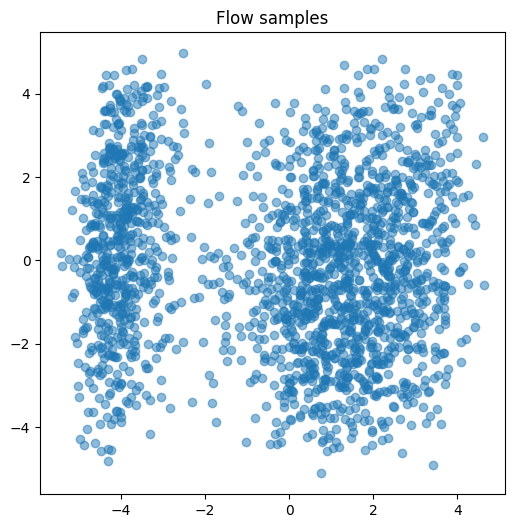

In [150]:
# fig, axs = plt.subplots(1, 3, figsize=(12,6), subplot_kw={'aspect': 'equal'})
# plot_flow_samples(model, axs[0], 100, args.batch_dim)

# plot_flow_samples(model, 40, args.batch_dim)

plot_samples(samples_flow, plot_dim_a, plot_dim_b)

torch.Size([10000, 43])
torch.Size([10000, 43])


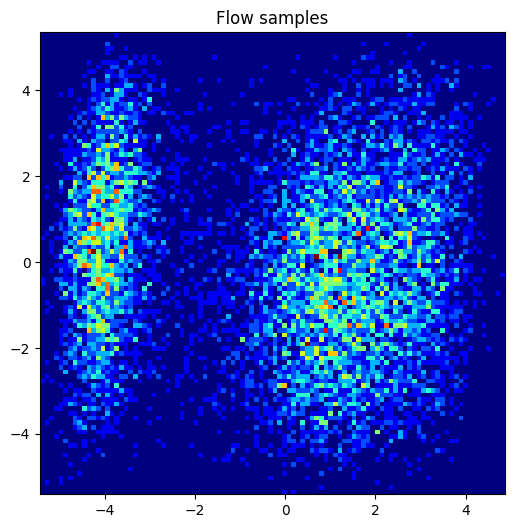

In [151]:
plot_flow_samples_hist(model, 100, 200, plot_dim_a, plot_dim_b)

In [152]:
compute_log_p_x(model, samples_flow.to(args.device)).mean()

tensor(-360.2052, device='cuda:0', grad_fn=<MeanBackward0>)

In [153]:
# plot_samples_density(model, 100, 10, 1, 2)

log probs:  tensor([-342.1273, -396.1093, -315.4790,  ..., -340.8131, -339.7935,
        -402.2273])


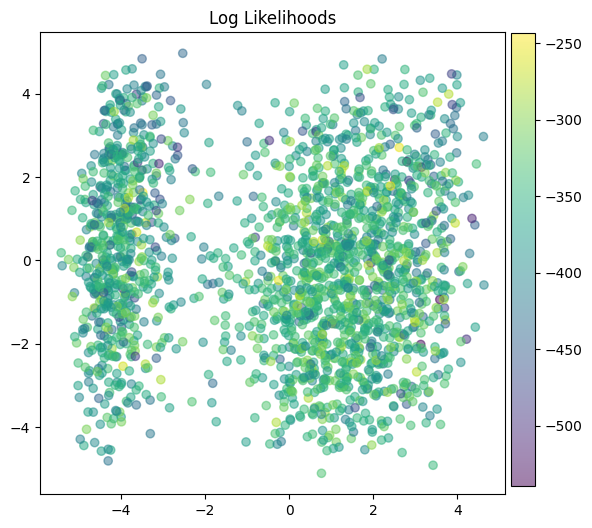

In [154]:
plot_samples_density(model, samples_flow, plot_dim_a, plot_dim_b, verbose=True)

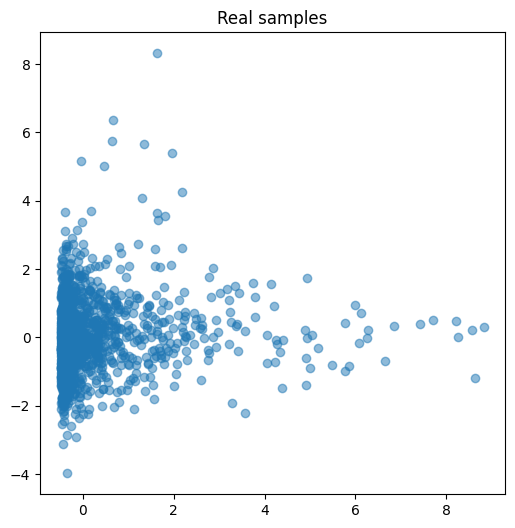

In [155]:
plot_samples(samples_training_data.cpu().detach(), plot_dim_a, plot_dim_b, title="Real samples")

In [156]:
compute_log_p_x(model, samples_training_data.to(args.device)).mean()

tensor(-6.8612, device='cuda:0', grad_fn=<MeanBackward0>)

log probs:  tensor([ 3.5601, -9.2201,  8.9017,  ..., -3.1207,  0.0514, -4.3292])


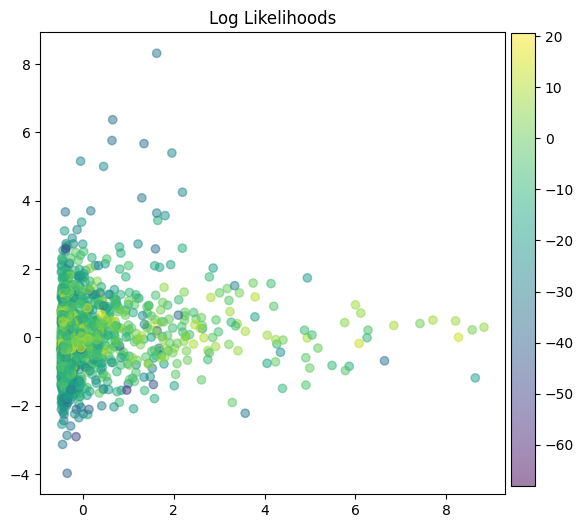

In [157]:
plot_samples_density(model, samples_training_data, plot_dim_a, plot_dim_b, verbose=True)

# Main Takeaways

It seems that BNAF is great at the density estimation game. It can learn seemingly reasonable densities for 2D distributions at least. In higher dimensions, such as in this MiniBooNe (43D) setting, the log likelihoods are somewhat high (we are actually reproducing more or less their results in their paper). However, the sampling appears to be terrible, even on 2D toy data. This speaks to some fundamental tradeoff between sample quality and density estimation. But in this case, I suspect BNAF sacrifices sampling somewhere in its architecture, in not really defining a base distribution? See the density estimation objective in *compute_kl_pq_loss* (which isn't used anywhere in the code, but defined probably in some other function)

In [158]:
# def plot_fwd_flow_density(model, test_grid, n_pts, batch_size):
#     """ plots square grid and flow density; where density under the flow is exp(log_flow_base_dist + logdet) """
#     xx, yy, zz = test_grid
#     # compute posterior approx density
#     zzk, logdets = [], []
#     for zz_i in zz.split(batch_size, dim=0):
#         # print(zz_i.shape)
#         zzk_i, logdets_i = model(zz_i)
#         zzk += [zzk_i]
#         logdets += [logdets_i]
#     zzk, logdets = torch.cat(zzk, 0), torch.cat(logdets, 0)
#     log_prob = base_dist.log_prob(zzk) + logdets
#     prob = log_prob.sum(1).exp().cpu()
#     # plot
#     plt.pcolormesh(xx, yy, prob.view(n_pts,n_pts), cmap=plt.cm.jet)
#     # plt.set_facecolor(plt.cm.jet(0.))
#     plt.set_title('Flow density')

In [159]:
# def setup_grid(range_lim, n_pts, args):
#     x = torch.linspace(-range_lim, range_lim, n_pts)
#     xx, yy = torch.meshgrid((x, x))
#     zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)
#     return xx, yy, zz.to(args.device)

In [160]:
# n_pts = 2000
# range_lim = 4

# # construct test points
# test_grid = setup_grid(range_lim, n_pts, args)

In [161]:
# fig = plt.plot(figsize=(8,4))
# plot_fwd_flow_density(model, test_grid, n_pts, args.batch_dim)